In [3]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate

### Points to Improve
- Not using z properly. Especially with interpolating
- Not doing cross validation properly. Pick out 1 in 5 and iterate. Find best test points to take out

In [5]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("SEOB_4D_MM_data.txt",names = columns)
datatab

,x,y,z,w,data,error
0,0.1,-1.439897,0.0,0.25,-2.831628,0.815517
1,0.1,-1.308997,0.5,0.25,-3.006489,0.926090
2,0.1,-1.178097,1.0,0.25,-2.354835,0.699513
3,0.1,-1.047198,1.0,0.25,-2.974002,0.712574
4,0.1,-0.916298,1.0,0.25,-2.401510,0.699986
...,...,...,...,...,...,...
995,0.7,1.570796,-1.0,1.00,-2.287634,0.687055
996,0.8,1.570796,-1.0,1.00,-2.164392,0.692650
997,0.9,1.570796,-1.0,1.00,-2.152368,0.693543
998,1.0,-1.439897,-1.0,1.00,-2.579505,1.226236


In [6]:
print(datatab.columns)

Index(['x', 'y', 'z', 'w', 'data', 'error'], dtype='object')


In [7]:
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

In [8]:
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values


print(xm1.shape)
print(ym1.shape)
print(dm1.shape)

(250,)
(250,)
(250,)


In [18]:
X = np.column_stack((xm1.ravel(), ym1.ravel(), zm1.ravel(), wm1.ravel()))
D = dm1.ravel().reshape(-1, 1)

guess_l = (1., 1., 1., 1.)
bounds_l = ((1e-20, 4.),) * 4
guess_n = 1.
bounds_n = (1e-20, 1.)

kernel = RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

X_train, X_test, Y_train, Y_test = train_test_split(X, D, train_size=0.8, random_state=1)
print(f"X_train shape: {X_train.shape}")

gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, Y_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Dfit, Dstd = gpr.predict(X, return_std=True)
Dstd = Dstd.reshape(xm1.shape)
Dfit = Dfit.reshape(xm1.shape)

print("Prediction completed.")

X_train shape: (200, 4)
Fitted Kernel: RBF(length_scale=[0.448, 1.01, 1.04, 1]) + WhiteKernel(noise_level=0.16)
Prediction completed.


In [24]:
x_coords = X_test[:,0]
y_coords = X_test[:,1]

# Flatten the 4D grid (xm1, ym1, zm1, wm1) to match the dimensionality of X_test
X_flat = np.column_stack((xm1.ravel(), ym1.ravel(), zm1.ravel(), wm1.ravel()))
D_true_flat = dm1.ravel()  # Flatten true data

# Find indices of test points in the flattened 4D grid
test_indices = np.array([np.where((X_flat == test_point).all(axis=1))[0][0] for test_point in X_test])

# Get true data values corresponding to test points
D_true_test = D_true_flat[test_indices]

print(D_true_test.shape)

# Get predicted values at test points
D_pred_test = gpr.predict(X_test)
print(D_pred_test.shape)

# Calculate relative differences
relative_difference = np.abs(D_true_test - D_pred_test) / np.abs(D_true_test)

# Print relative differences
print("Relative Differences at Test Points:", relative_difference)
print(relative_difference.shape)

(50,)
(50,)
Relative Differences at Test Points: [0.01181794 0.02558705 0.02881452 0.05072587 0.05160927 0.00113906
 0.05492541 0.09122532 0.01858812 0.22278328 0.03919341 0.00889146
 0.01659652 0.00355146 0.04540191 0.00382539 0.00226807 0.00279745
 0.06371597 0.03642831 0.0679003  0.0607732  0.01685601 0.00215799
 0.03789407 0.03453572 0.06935103 0.02570401 0.12892766 0.0689634
 0.05872702 0.14637216 0.00269112 0.01537387 0.03543737 0.11363488
 0.04465925 0.00443929 0.18466261 0.08166231 0.08093654 0.09670612
 0.00967176 0.06076982 0.00054325 0.07512626 0.03158902 0.03824983
 0.02937064 0.01749198]
(50,)


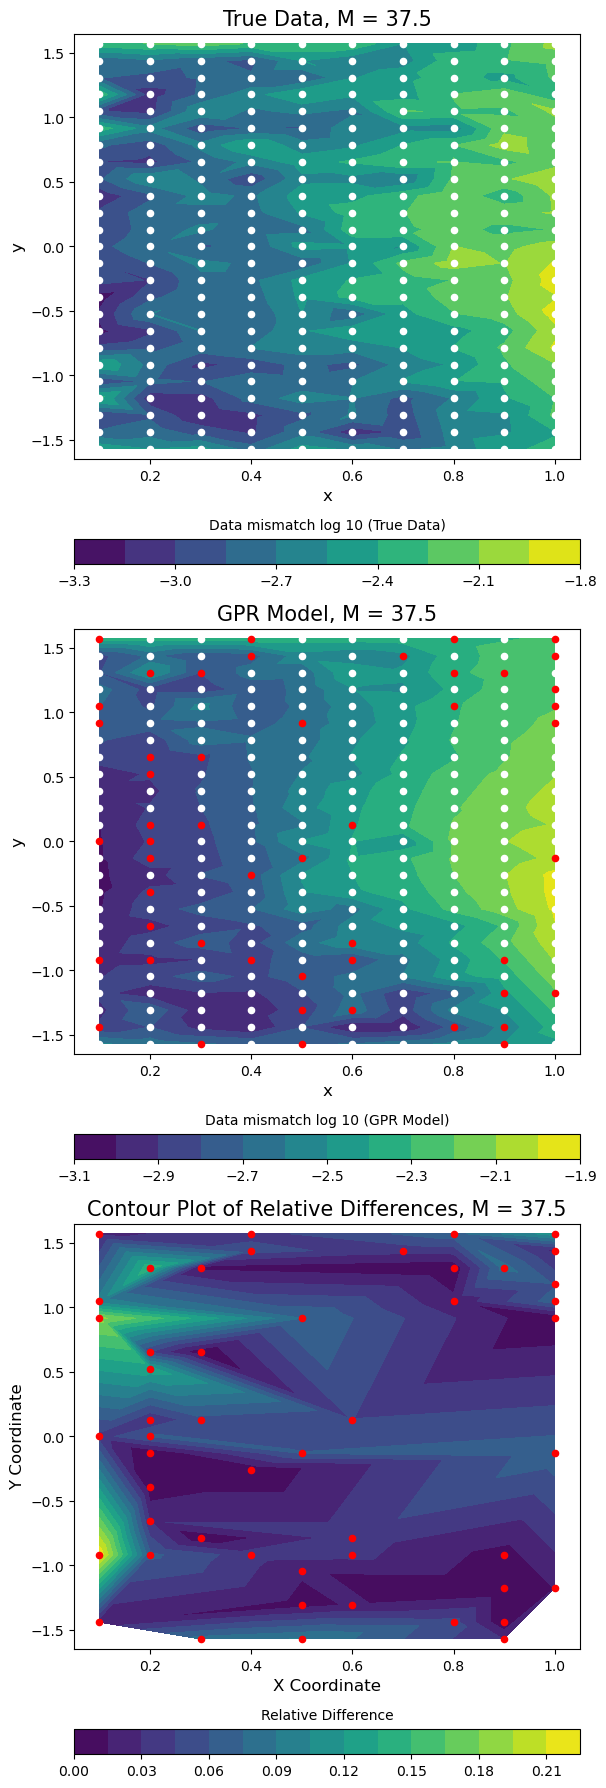

In [9]:
# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

# Plot True Data
contour1 = axes[0].tricontourf(xm1, ym1, dm1, levels=10, cmap="viridis")
axes[0].set_xlim((0.05, 1.05))
axes[0].set_ylim((-1.65, 1.65))
axes[0].scatter(xm1, ym1, s = 20,color='white')
axes[0].set_title('True Data, M = 37.5', size=15)
axes[0].set_xlabel('x', size=12)
axes[0].set_ylabel('y', size=12)
cbar1 = fig.colorbar(contour1, ax=axes[0], orientation='horizontal', fraction=0.05, pad=0.15)
cbar1.set_label("Data mismatch log 10 (True Data)", size=10, labelpad=-50, loc='center')  # Title above

# Plot GPR Model
contour2 = axes[1].tricontourf(xm1, ym1, Dfit, levels=10, cmap="viridis")
axes[1].scatter(X_train[:, 0], X_train[:, 1], s=20, color='white', label='Train')
axes[1].scatter(X_test[:, 0], X_test[:, 1], s=20, color='red', label='Test')
axes[1].set_xlim((0.05, 1.05))
axes[1].set_ylim((-1.65, 1.65))
axes[1].set_title('GPR Model, M = 37.5', size=15)
axes[1].set_xlabel('x', size=12)
axes[1].set_ylabel('y', size=12)
cbar2 = fig.colorbar(contour2, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.15)
cbar2.set_label("Data mismatch log 10 (GPR Model)", size=10, labelpad=-50, loc='center')  # Title above

# Plot Relative Differences
contour3 = axes[2].tricontourf(x_coords, y_coords, relative_difference, levels=20, cmap='viridis')
axes[2].scatter(x_coords, y_coords,s=20, c='red')
axes[2].set_xlim((0.05, 1.05))
axes[2].set_ylim((-1.65, 1.65))
axes[2].set_title('Contour Plot of Relative Differences, M = 37.5', size=15)
axes[2].set_xlabel('X Coordinate', size=12)
axes[2].set_ylabel('Y Coordinate', size=12)
cbar3 = fig.colorbar(contour3, ax=axes[2], orientation='horizontal', fraction=0.05, pad=0.15)
cbar3.set_label("Relative Difference", size=10, labelpad=-50, loc='center')  # Title above

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values


print(xm2.shape)
print(ym2.shape)
print(dm2.shape)
print(xm2)

(250,)
(250,)
(250,)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 0.8 0.7 0.6
 0.5 0.4 0.3 0.2 0.1 0.1 0.2 0.

In [11]:
X2 = np.column_stack((xm2.ravel(), ym2.ravel(), zm2.ravel(), wm2.ravel()))
D2 = dm2.ravel().reshape(-1, 1)

guess_l = (1., 1., 1., 1.)
bounds_l = ((1e-20, 4.),) * 4
guess_n = 1.
bounds_n = (1e-20, 1.)

kernel2 = RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, D2, train_size=0.8, random_state=3)
print(f"X_train shape: {X_train2.shape}")

gpr = GaussianProcessRegressor(kernel=kernel2, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train2, Y_train2)
print(f"Fitted Kernel: {gpr.kernel_}")

Dfit2, Dstd2 = gpr.predict(X2, return_std=True)
Dstd2 = Dstd2.reshape(xm2.shape)
Dfit2 = Dfit2.reshape(xm2.shape)

print("Prediction completed.")

X_train shape: (200, 4)
Fitted Kernel: RBF(length_scale=[0.437, 0.872, 0.892, 1]) + WhiteKernel(noise_level=0.182)
Prediction completed.


In [12]:
x_coords2 = X_test2[:,0]
y_coords2 = X_test2[:,1]

# Flatten the 4D grid (xm1, ym1, zm1, wm1) to match the dimensionality of X_test
X_flat2 = np.column_stack((xm2.ravel(), ym2.ravel(), zm2.ravel(), wm2.ravel()))
D_true_flat2 = dm2.ravel()  # Flatten true data

# Find indices of test points in the flattened 4D grid
test_indices2 = np.array([np.where((X_flat2 == test_point).all(axis=1))[0][0] for test_point in X_test2])

# Get true data values corresponding to test points
D_true_test2 = D_true_flat2[test_indices2]

# Get predicted values at test points
D_pred_test2 = gpr.predict(X_test2)

# Calculate relative differences
relative_difference2 = np.abs(D_true_test2 - D_pred_test2) / np.abs(D_true_test2)

# Print relative differences
print("Relative Differences at Test Points:", relative_difference2)

Relative Differences at Test Points: [0.09247584 0.11011423 0.0034022  0.09727713 0.01583059 0.11297898
 0.09741021 0.00017686 0.08090293 0.01056559 0.02849285 0.04402418
 0.02651111 0.04364471 0.02623298 0.05092695 0.00850684 0.05873451
 0.0275403  0.04625718 0.09133643 0.10024491 0.06639355 0.00176364
 0.06787111 0.00656653 0.0970846  0.04217984 0.02873248 0.02159029
 0.05859056 0.05570098 0.00501655 0.00828938 0.00822571 0.00938259
 0.03920147 0.01854894 0.01026309 0.01337375 0.09644413 0.00461294
 0.04556153 0.04357324 0.05433827 0.0394937  0.0452762  0.05259462
 0.01288649 0.00090741]


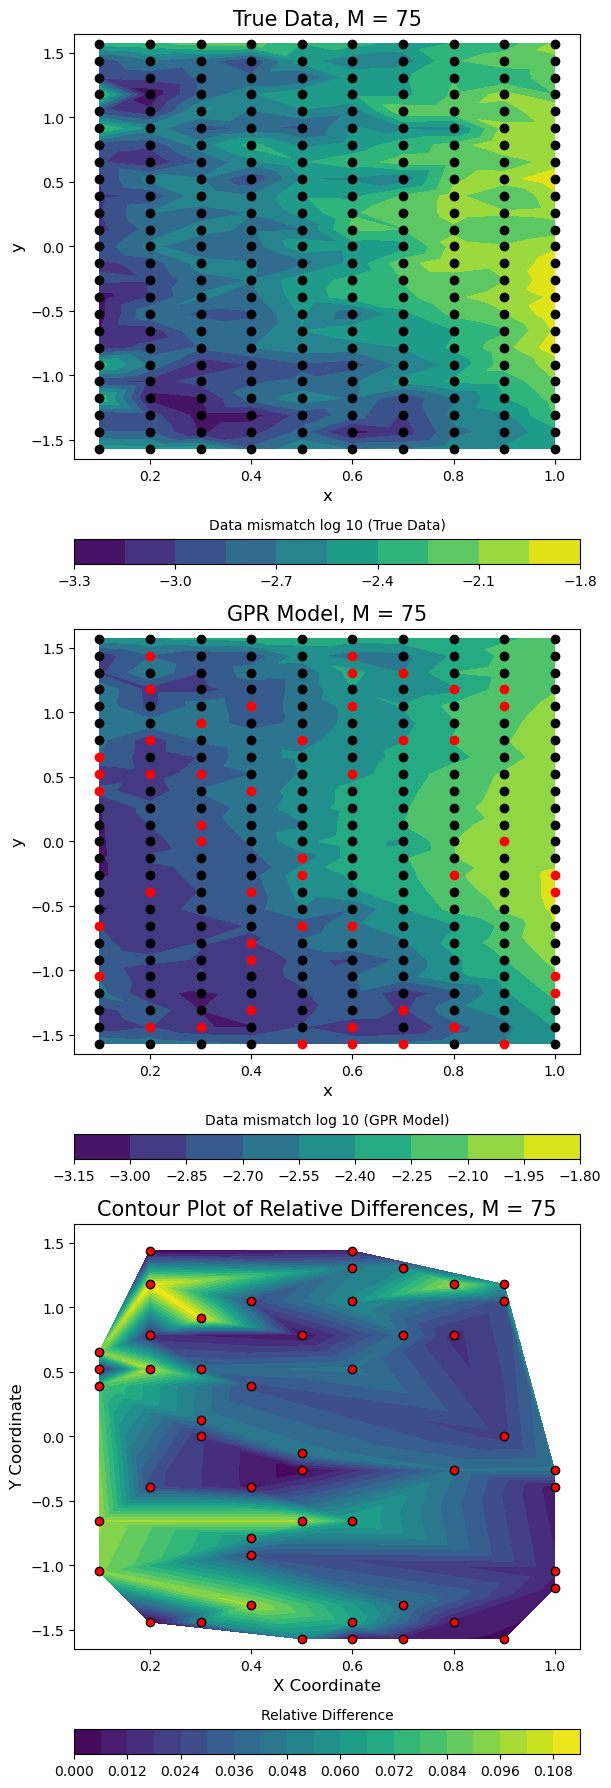

In [13]:
# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

# Plot True Data
contour21 = axes[0].tricontourf(xm2, ym2, dm2, levels=10, cmap="viridis")
axes[0].set_xlim((0.05, 1.05))
axes[0].set_ylim((-1.65, 1.65))
axes[0].plot(xm2, ym2, 'ko')
axes[0].set_title('True Data, M = 75', size=15)
axes[0].set_xlabel('x', size=12)
axes[0].set_ylabel('y', size=12)
cbar21 = fig.colorbar(contour21, ax=axes[0], orientation='horizontal', fraction=0.05, pad=0.15)
cbar21.set_label("Data mismatch log 10 (True Data)", size=10, labelpad=-50, loc='center')  # Title above

# Plot GPR Model
contour22 = axes[1].tricontourf(xm2, ym2, Dfit2, levels=10, cmap="viridis")
axes[1].plot(X_train2[:, 0], X_train2[:, 1], 'o', color='black', label='Train')
axes[1].plot(X_test2[:, 0], X_test2[:, 1], 'o', color='red', label='Test')
axes[1].set_xlim((0.05, 1.05))
axes[1].set_ylim((-1.65, 1.65))
axes[1].set_title('GPR Model, M = 75', size=15)
axes[1].set_xlabel('x', size=12)
axes[1].set_ylabel('y', size=12)
cbar22 = fig.colorbar(contour22, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.15)
cbar22.set_label("Data mismatch log 10 (GPR Model)", size=10, labelpad=-50, loc='center')  # Title above

# Plot Relative Differences
contour32 = axes[2].tricontourf(x_coords2, y_coords2, relative_difference2, levels=20, cmap='viridis')
axes[2].scatter(x_coords2, y_coords2, c='red', edgecolor='k')
axes[2].set_xlim((0.05, 1.05))
axes[2].set_ylim((-1.65, 1.65))
axes[2].set_title('Contour Plot of Relative Differences, M = 75', size=15)
axes[2].set_xlabel('X Coordinate', size=12)
axes[2].set_ylabel('Y Coordinate', size=12)
cbar32 = fig.colorbar(contour32, ax=axes[2], orientation='horizontal', fraction=0.05, pad=0.15)
cbar32.set_label("Relative Difference", size=10, labelpad=-50, loc='center')  # Title above

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values


print(xm3.shape)
print(ym3.shape)
print(dm3.shape)
print(xm3)

(250,)
(250,)
(250,)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 0.8 0.7 0.6
 0.5 0.4 0.3 0.2 0.1 0.1 0.2 0.

In [15]:
X3 = np.column_stack((xm3.ravel(), ym3.ravel(), zm3.ravel(), wm3.ravel()))
D3 = dm3.ravel().reshape(-1, 1)

guess_l = (1., 1., 1., 1.)
bounds_l = ((1e-20, 4.),) * 4
guess_n = 1.
bounds_n = (1e-20, 1.)

kernel3 = RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, D3, train_size=0.8, random_state=5)
print(f"X_train shape: {X_train3.shape}")

gpr = GaussianProcessRegressor(kernel=kernel3, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train3, Y_train3)
print(f"Fitted Kernel: {gpr.kernel_}")

Dfit3, Dstd3 = gpr.predict(X3, return_std=True)
Dstd3 = Dstd3.reshape(xm3.shape)
Dfit3 = Dfit3.reshape(xm3.shape)

print("Prediction completed.")

X_train shape: (200, 4)
Fitted Kernel: RBF(length_scale=[0.387, 0.915, 0.843, 1]) + WhiteKernel(noise_level=0.168)
Prediction completed.


In [16]:
x_coords3 = X_test3[:,0]
y_coords3 = X_test3[:,1]

# Flatten the 4D grid (xm1, ym1, zm1, wm1) to match the dimensionality of X_test
X_flat3 = np.column_stack((xm3.ravel(), ym3.ravel(), zm3.ravel(), wm3.ravel()))
D_true_flat3 = dm3.ravel()  # Flatten true data

# Find indices of test points in the flattened 4D grid
test_indices3 = np.array([np.where((X_flat3 == test_point).all(axis=1))[0][0] for test_point in X_test3])

# Get true data values corresponding to test points
D_true_test3 = D_true_flat3[test_indices3]

# Get predicted values at test points
D_pred_test3 = gpr.predict(X_test3)

# Calculate relative differences
relative_difference3 = np.abs(D_true_test3 - D_pred_test3) / np.abs(D_true_test3)

# Print relative differences
print("Relative Differences at Test Points:", relative_difference3)

Relative Differences at Test Points: [0.0387569  0.14807544 0.06814015 0.01636767 0.03689945 0.08742786
 0.02916614 0.06286996 0.0192285  0.00478388 0.07700432 0.02700312
 0.017801   0.12037105 0.01179015 0.0373394  0.02216755 0.02421822
 0.02407916 0.09795126 0.03942528 0.08655273 0.01090017 0.05978013
 0.01033408 0.08215493 0.12142988 0.00969887 0.0349807  0.00880818
 0.05752303 0.05953029 0.02233236 0.08464135 0.01319938 0.01997141
 0.09243056 0.05892549 0.07226729 0.01861515 0.0111514  0.00826712
 0.06172897 0.06645494 0.02749017 0.09280673 0.02202437 0.0687436
 0.07078579 0.02450107]


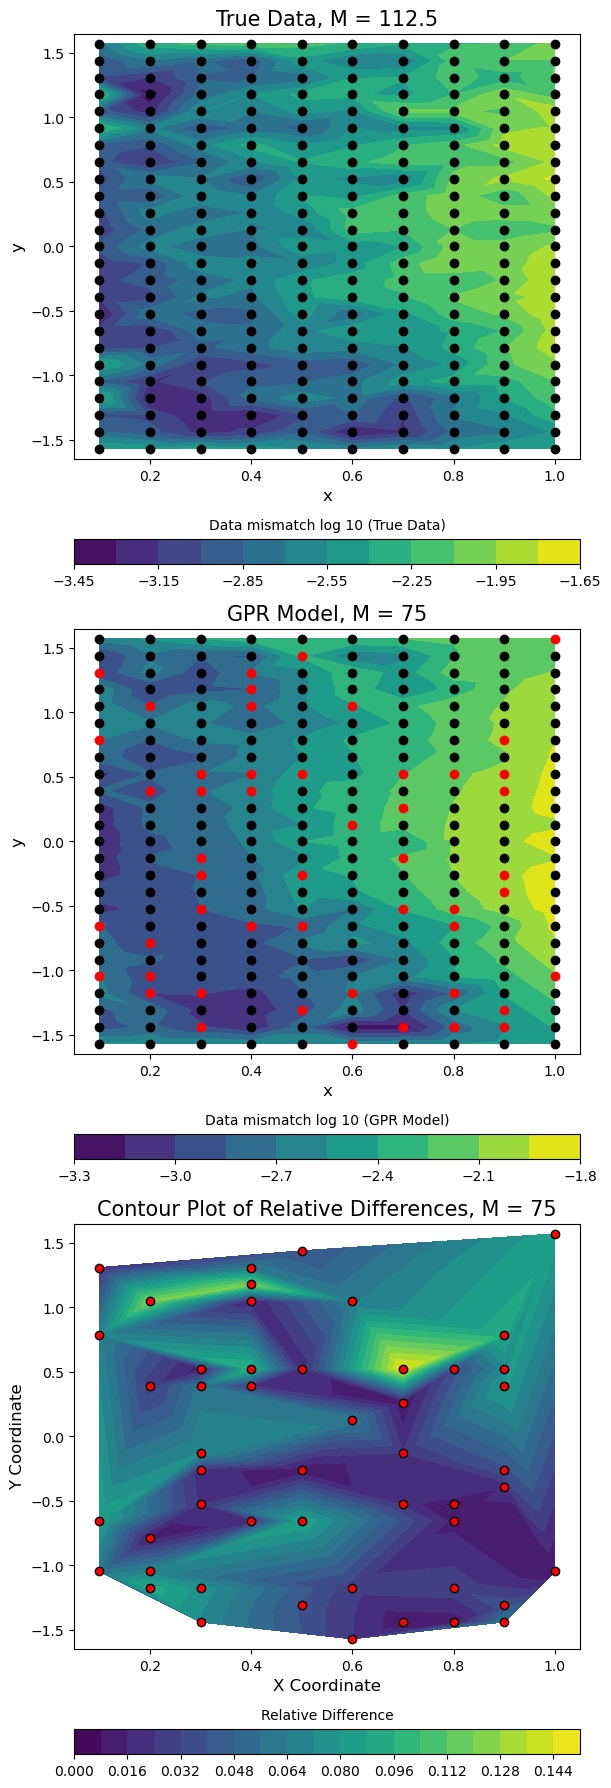

In [17]:
# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

# Plot True Data
contour31 = axes[0].tricontourf(xm3, ym3, dm3, levels=10, cmap="viridis")
axes[0].set_xlim((0.05, 1.05))
axes[0].set_ylim((-1.65, 1.65))
axes[0].plot(xm3, ym3, 'ko')
axes[0].set_title('True Data, M = 112.5', size=15)
axes[0].set_xlabel('x', size=12)
axes[0].set_ylabel('y', size=12)
cbar31 = fig.colorbar(contour31, ax=axes[0], orientation='horizontal', fraction=0.05, pad=0.15)
cbar31.set_label("Data mismatch log 10 (True Data)", size=10, labelpad=-50, loc='center')  # Title above

# Plot GPR Model
contour23 = axes[1].tricontourf(xm3, ym3, Dfit3, levels=10, cmap="viridis")
axes[1].plot(X_train3[:, 0], X_train3[:, 1], 'o', color='black', label='Train')
axes[1].plot(X_test3[:, 0], X_test3[:, 1], 'o', color='red', label='Test')
axes[1].set_xlim((0.05, 1.05))
axes[1].set_ylim((-1.65, 1.65))
axes[1].set_title('GPR Model, M = 75', size=15)
axes[1].set_xlabel('x', size=12)
axes[1].set_ylabel('y', size=12)
cbar23 = fig.colorbar(contour23, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.15)
cbar23.set_label("Data mismatch log 10 (GPR Model)", size=10, labelpad=-50, loc='center')  # Title above

# Plot Relative Differences
contour33 = axes[2].tricontourf(x_coords3, y_coords3, relative_difference3, levels=20, cmap='viridis')
axes[2].scatter(x_coords3, y_coords3, c='red', edgecolor='k')
axes[2].set_xlim((0.05, 1.05))
axes[2].set_ylim((-1.65, 1.65))
axes[2].set_title('Contour Plot of Relative Differences, M = 75', size=15)
axes[2].set_xlabel('X Coordinate', size=12)
axes[2].set_ylabel('Y Coordinate', size=12)
cbar33 = fig.colorbar(contour33, ax=axes[2], orientation='horizontal', fraction=0.05, pad=0.15)
cbar33.set_label("Relative Difference", size=10, labelpad=-50, loc='center')  # Title above

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values


print(xm4.shape)
print(ym4.shape)
print(dm4.shape)
print(xm4)

(250,)
(250,)
(250,)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 0.8 0.7 0.6
 0.5 0.4 0.3 0.2 0.1 0.1 0.2 0.

In [19]:
X4 = np.column_stack((xm4.ravel(), ym4.ravel(), zm4.ravel(), wm4.ravel()))
D4 = dm4.ravel().reshape(-1, 1)

guess_l = (1., 1., 1., 1.)
bounds_l = ((1e-20, 4.),) * 4
guess_n = 1.
bounds_n = (1e-20, 1.)

kernel4 = RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X3, D3, train_size=0.8, random_state=6)
print(f"X_train shape: {X_train4.shape}")

gpr = GaussianProcessRegressor(kernel=kernel4, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train4, Y_train4)
print(f"Fitted Kernel: {gpr.kernel_}")

Dfit4, Dstd4 = gpr.predict(X4, return_std=True)
Dstd4 = Dstd4.reshape(xm4.shape)
Dfit4 = Dfit4.reshape(xm4.shape)

print("Prediction completed.")

X_train shape: (200, 4)
Fitted Kernel: RBF(length_scale=[0.318, 0.814, 1.01, 1]) + WhiteKernel(noise_level=0.147)
Prediction completed.


In [20]:
x_coords4 = X_test4[:,0]
y_coords4 = X_test4[:,1]

# Flatten the 4D grid (xm1, ym1, zm1, wm1) to match the dimensionality of X_test
X_flat4 = np.column_stack((xm4.ravel(), ym4.ravel(), zm4.ravel(), wm4.ravel()))
D_true_flat4 = dm4.ravel()  # Flatten true data

# Find indices of test points in the flattened 4D grid
### Bit allege
test_indices4 = np.array([
    np.argmin(np.linalg.norm(X_flat4 - test_point, axis=1))
    for test_point in X_test4
])

# Get true data values corresponding to test points
D_true_test4 = D_true_flat4[test_indices4]

# Get predicted values at test points
D_pred_test4 = gpr.predict(X_test4)

# Calculate relative differences
relative_difference4 = np.abs(D_true_test4 - D_pred_test4) / np.abs(D_true_test4)

# Print relative differences
print("Relative Differences at Test Points:", relative_difference4)

Relative Differences at Test Points: [0.01375429 0.06112603 0.02538839 0.02015928 0.08345662 0.03966235
 0.05659886 0.11846986 0.02890558 0.06569492 0.06150099 0.00147526
 0.00610904 0.15775692 0.03126635 0.04682637 0.09187137 0.01792086
 0.12856699 0.06459829 0.0569514  0.00981718 0.03057753 0.06955595
 0.08134025 0.06925153 0.08396533 0.07577026 0.05221851 0.01464791
 0.10526989 0.03981024 0.10047063 0.03960972 0.0521997  0.01576407
 0.04259286 0.12311482 0.0575984  0.05017942 0.05900432 0.06963604
 0.03479831 0.00717645 0.03026473 0.08345968 0.05044044 0.00915343
 0.11666324 0.01895459]


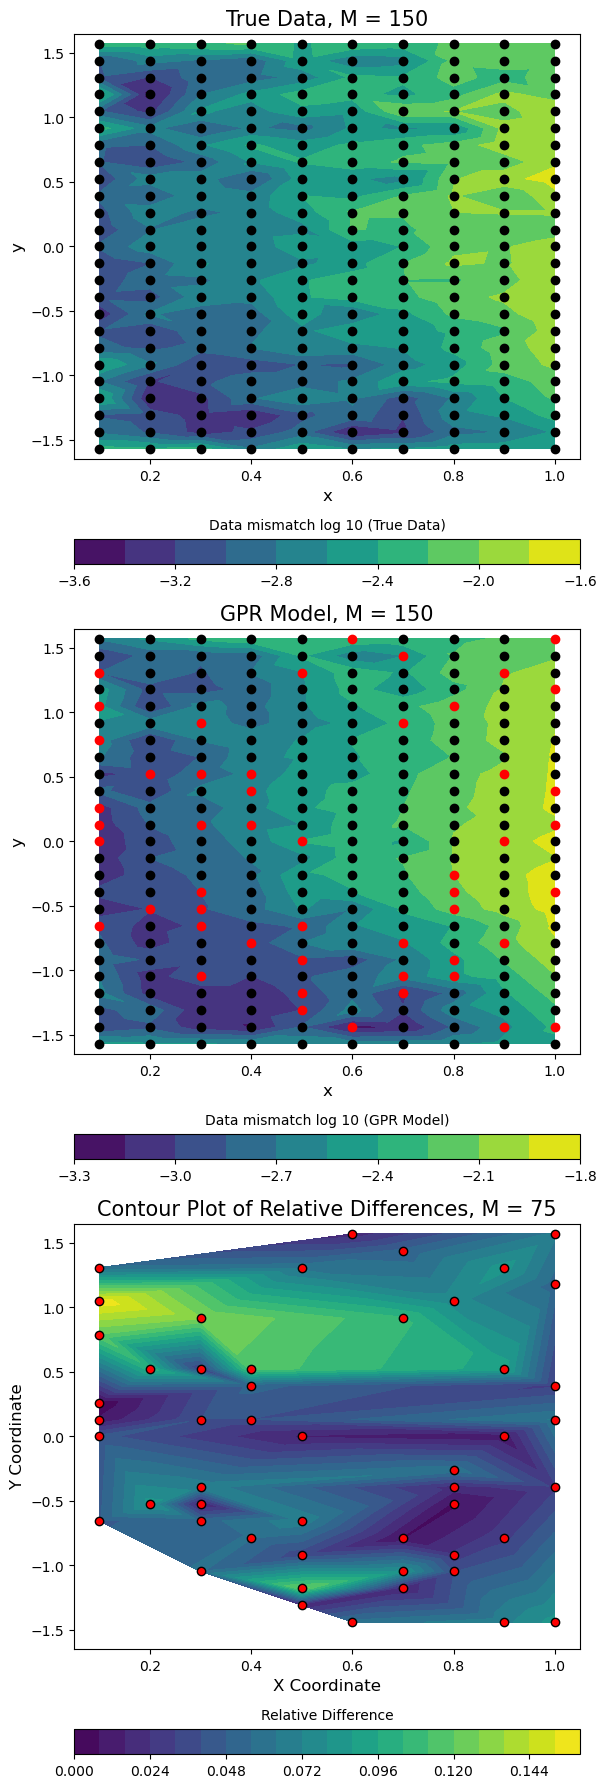

In [21]:
# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

# Plot True Data
contour41 = axes[0].tricontourf(xm4, ym4, dm4, levels=10, cmap="viridis")
axes[0].set_xlim((0.05, 1.05))
axes[0].set_ylim((-1.65, 1.65))
axes[0].plot(xm4, ym4, 'ko')
axes[0].set_title('True Data, M = 150', size=15)
axes[0].set_xlabel('x', size=12)
axes[0].set_ylabel('y', size=12)
cbar41 = fig.colorbar(contour41, ax=axes[0], orientation='horizontal', fraction=0.05, pad=0.15)
cbar41.set_label("Data mismatch log 10 (True Data)", size=10, labelpad=-50, loc='center')  # Title above

# Plot GPR Model
contour24 = axes[1].tricontourf(xm4, ym4, Dfit4, levels=10, cmap="viridis")
axes[1].plot(X_train4[:, 0], X_train4[:, 1], 'o', color='black', label='Train')
axes[1].plot(X_test4[:, 0], X_test4[:, 1], 'o', color='red', label='Test')
axes[1].set_xlim((0.05, 1.05))
axes[1].set_ylim((-1.65, 1.65))
axes[1].set_title('GPR Model, M = 150', size=15)
axes[1].set_xlabel('x', size=12)
axes[1].set_ylabel('y', size=12)
cbar24 = fig.colorbar(contour24, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.15)
cbar24.set_label("Data mismatch log 10 (GPR Model)", size=10, labelpad=-50, loc='center')  # Title above

# Plot Relative Differences
contour34 = axes[2].tricontourf(x_coords4, y_coords4, relative_difference4, levels=20, cmap='viridis')
axes[2].scatter(x_coords4, y_coords4, c='red', edgecolor='k')
axes[2].set_xlim((0.05, 1.05))
axes[2].set_ylim((-1.65, 1.65))
axes[2].set_title('Contour Plot of Relative Differences, M = 75', size=15)
axes[2].set_xlabel('X Coordinate', size=12)
axes[2].set_ylabel('Y Coordinate', size=12)
cbar34 = fig.colorbar(contour34, ax=axes[2], orientation='horizontal', fraction=0.05, pad=0.15)
cbar34.set_label("Relative Difference", size=10, labelpad=-50, loc='center')  # Title above

# Adjust layout
plt.tight_layout()
plt.show()

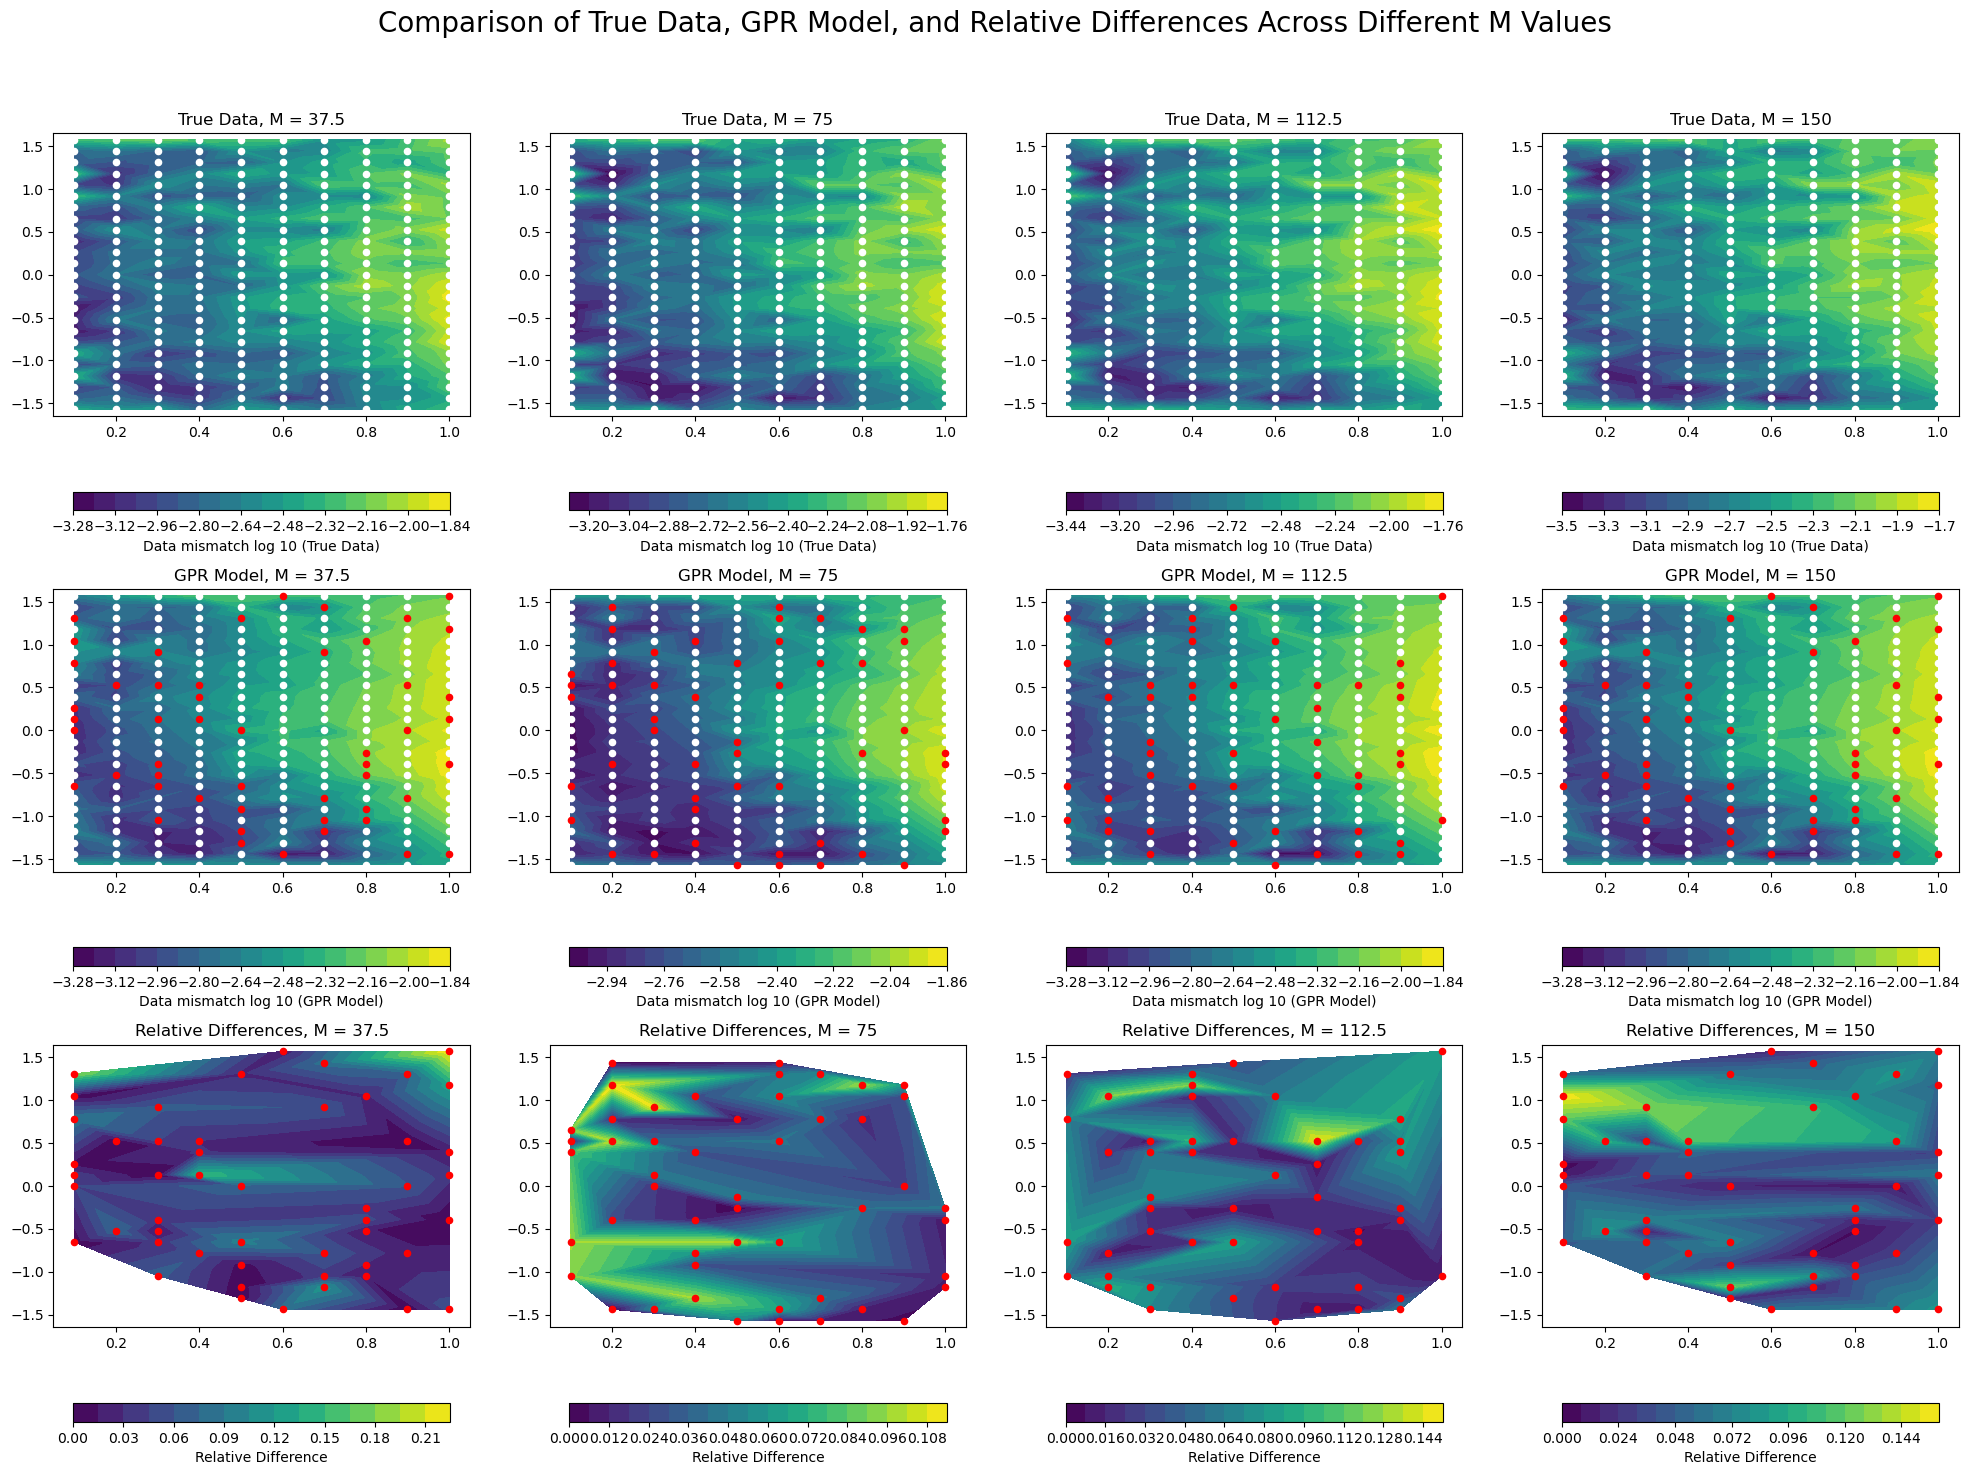

In [89]:
# Create a figure and axes for 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Set the figure title
fig.suptitle('Comparison of True Data, GPR Model, and Relative Differences Across Different M Values', size=20)



# Data for the plots
datasets = [
    (xm1, ym1, dm1, Dfit, X_train, X_test, x_coords, y_coords, relative_difference, 'M = 37.5'),
    (xm2, ym2, dm2, Dfit2, X_train2, X_test2, x_coords2, y_coords2, relative_difference2, 'M = 75'),
    (xm3, ym3, dm3, Dfit3, X_train3, X_test3, x_coords3, y_coords3, relative_difference3, 'M = 112.5'),
    (xm4, ym4, dm4, Dfit4, X_train4, X_test4, x_coords4, y_coords4, relative_difference4, 'M = 150'),
]

viridis_highcontrast = LinearSegmentedColormap.from_list("viridis_highcontrast", plt.cm.viridis(np.linspace(0, 1, 100)))

# Loop through each dataset and plot in the respective subplot
for col, (xm, ym, dm, Dfit, X_train, X_test, x_coords, y_coords, rel_diff, title) in enumerate(datasets):
    # Plot True Data
    contour1 = axes[0, col].tricontourf(xm, ym, dm, levels=20, cmap=viridis_highcontrast)
    axes[0, col].set_xlim((0.05, 1.05))
    axes[0, col].set_ylim((-1.65, 1.65))
    axes[0, col].scatter(xm, ym, s = 20, color = 'white')
    axes[0, col].set_title(f'True Data, {title}', size=12)
    cbar1 = fig.colorbar(contour1, ax=axes[0, col], orientation='horizontal', fraction=0.05, pad=0.2)
    cbar1.set_label("Data mismatch log 10 (True Data)", size=10)

    # Plot GPR Model
    contour2 = axes[1, col].tricontourf(xm, ym, Dfit, levels=20, cmap=viridis_highcontrast)
    axes[1, col].scatter(X_train[:, 0], X_train[:, 1],s = 20, color = 'white', label='Train')
    axes[1, col].scatter(X_test[:, 0], X_test[:, 1], s = 20, color = 'red', label='Test')
    axes[1, col].set_xlim((0.05, 1.05))
    axes[1, col].set_ylim((-1.65, 1.65))
    axes[1, col].set_title(f'GPR Model, {title}', size=12)
    cbar2 = fig.colorbar(contour2, ax=axes[1, col], orientation='horizontal', fraction=0.05, pad=0.2)
    cbar2.set_label("Data mismatch log 10 (GPR Model)", size=10)

    # Plot Relative Differences
    contour3 = axes[2, col].tricontourf(x_coords, y_coords, rel_diff, levels=20, cmap=viridis_highcontrast)
    axes[2, col].scatter(x_coords, y_coords,s=20, c='red')
    axes[2, col].set_xlim((0.05, 1.05))
    axes[2, col].set_ylim((-1.65, 1.65))
    axes[2, col].set_title(f'Relative Differences, {title}', size=12)
    cbar3 = fig.colorbar(contour3, ax=axes[2, col], orientation='horizontal', fraction=0.05, pad=0.2)
    cbar3.set_label("Relative Difference", size=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to leave space for the main title
plt.show()


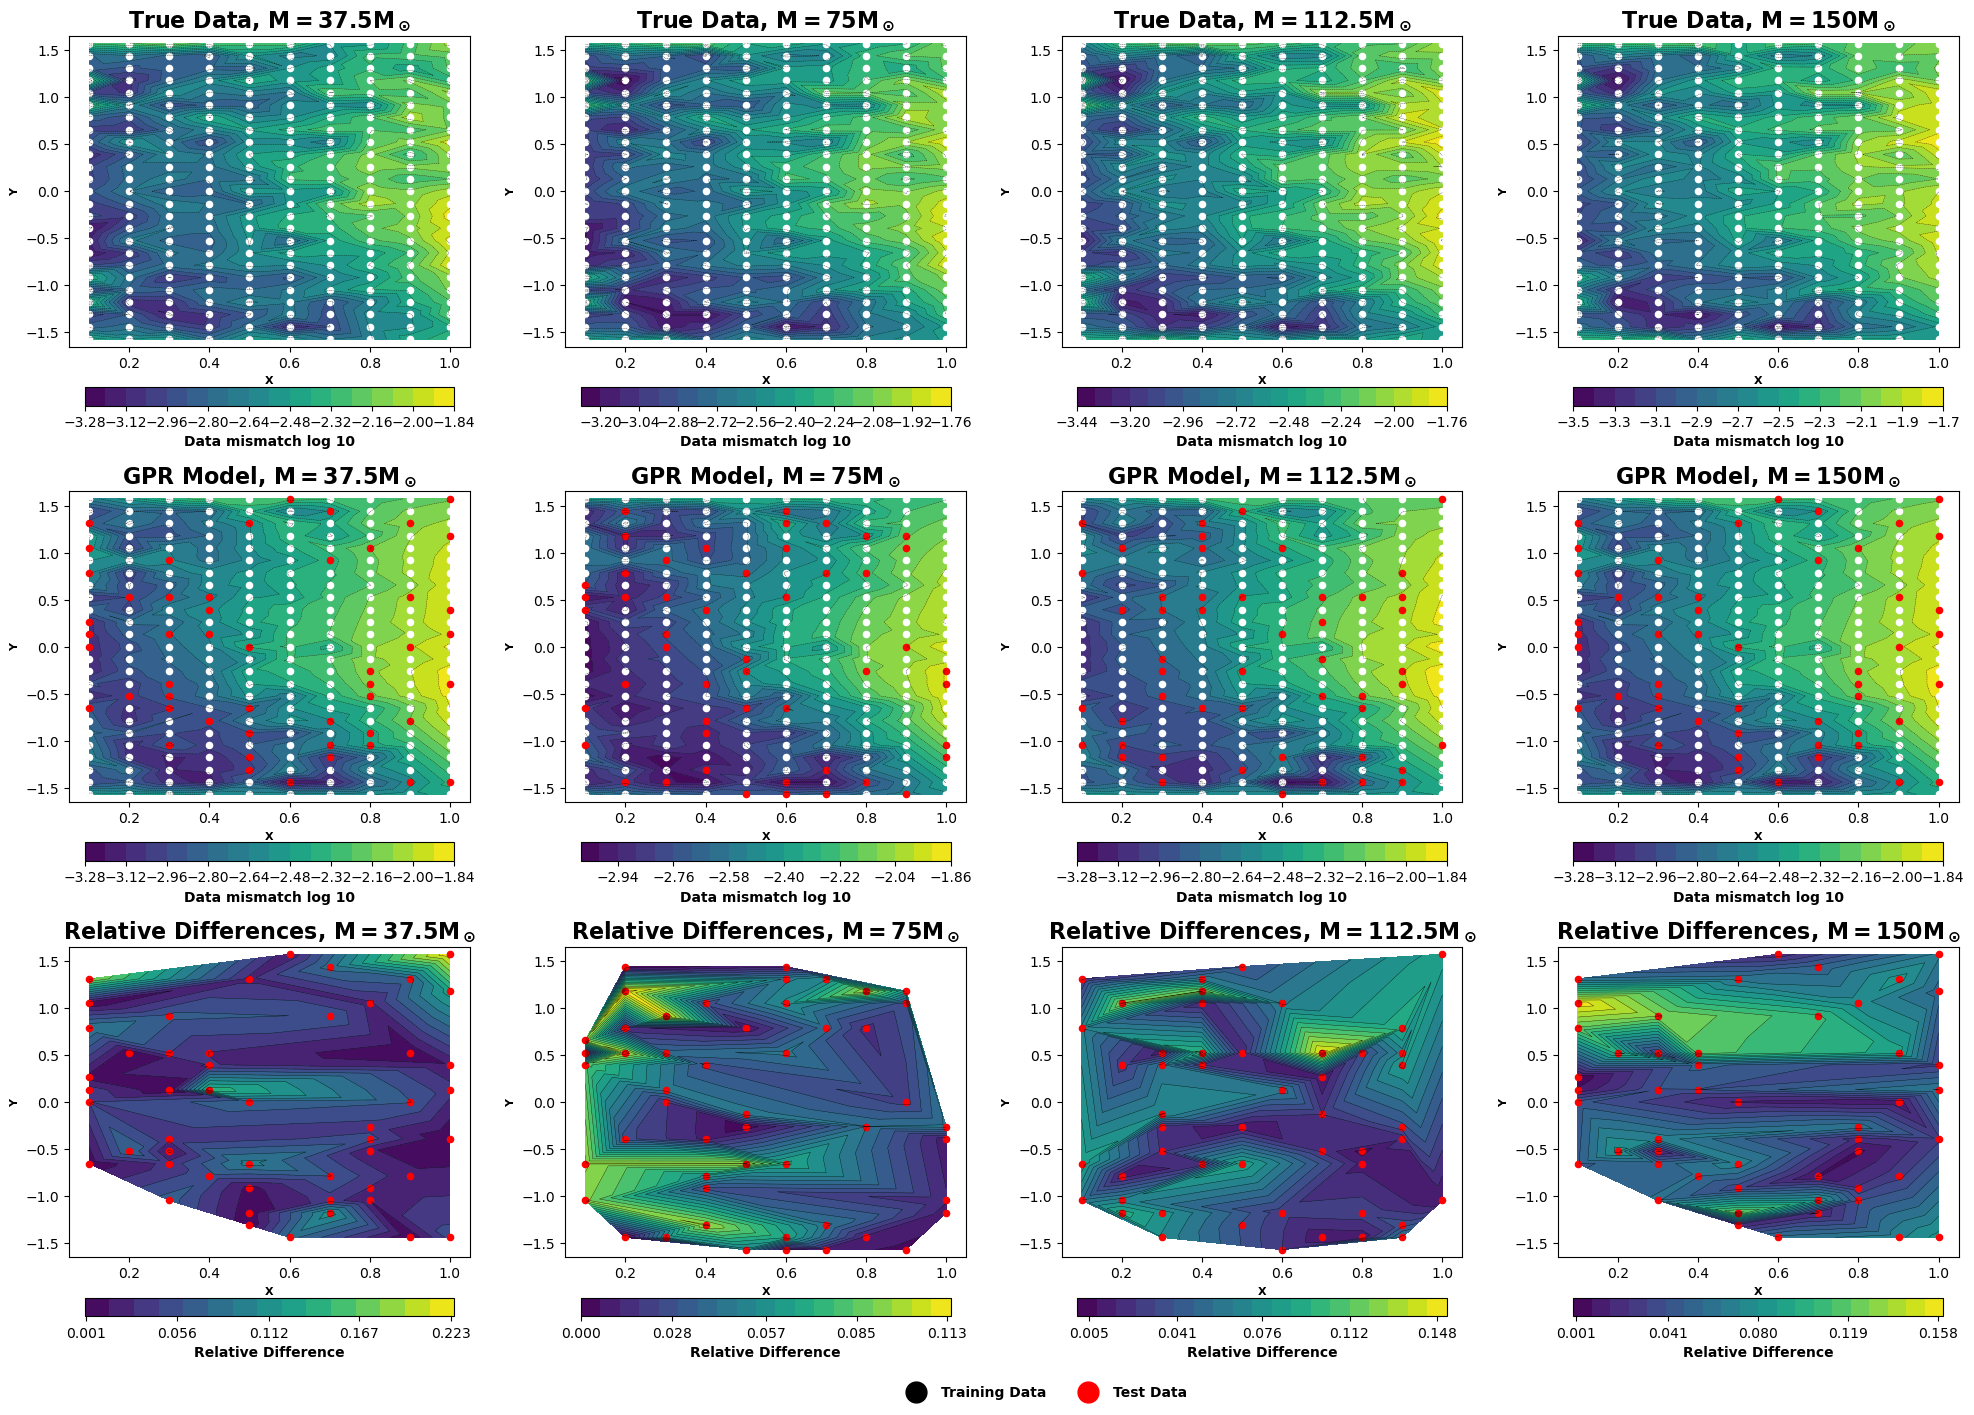

In [132]:
# Create a figure and axes for 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Data for the plots
datasets = [
    (xm1, ym1, dm1, Dfit, X_train, X_test, x_coords, y_coords, relative_difference, r'$\mathbf{M = 37.5M_\odot}$'),
    (xm2, ym2, dm2, Dfit2, X_train2, X_test2, x_coords2, y_coords2, relative_difference2, r'$\mathbf{M = 75M_\odot}$'),
    (xm3, ym3, dm3, Dfit3, X_train3, X_test3, x_coords3, y_coords3, relative_difference3, r'$\mathbf{M = 112.5M_\odot}$'),
    (xm4, ym4, dm4, Dfit4, X_train4, X_test4, x_coords4, y_coords4, relative_difference4, r'$\mathbf{M = 150M_\odot}$'),
]


viridis_highcontrast = LinearSegmentedColormap.from_list("viridis_highcontrast", plt.cm.viridis(np.linspace(0, 1, 100)))


# Loop through each dataset and plot in the respective subplot
for col, (xm, ym, dm, Dfit, X_train, X_test, x_coords, y_coords, rel_diff, title) in enumerate(datasets):
    # Plot True Data
    contour1 = axes[0, col].tricontourf(xm, ym, dm, levels=20, cmap=viridis_highcontrast)
    axes[0, col].tricontour(xm, ym, dm, levels=20, colors='black', linewidths=0.25)
    axes[0, col].scatter(xm, ym, s=20,c='white')
    axes[0, col].set_xlim((0.05, 1.05))
    axes[0, col].set_ylim((-1.65, 1.65))
    axes[0, col].set_title(f'True Data, {title}', size=16, weight='bold')
    axes[0, col].set_xlabel('X', size=8, weight='bold')
    axes[0, col].set_ylabel('Y', size=8, weight='bold')
    cbar1 = fig.colorbar(contour1, ax=axes[0, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar1.set_label("Data mismatch log 10", size=10, weight='bold')
    #cbar1.set_ticks(np.around(np.linspace(dm.min(), dm.max(), 5), 1))  # 1 decimal place

    # Plot GPR Model
    contour2 = axes[1, col].tricontourf(xm, ym, Dfit, levels=20, cmap=viridis_highcontrast)
    axes[1, col].tricontour(xm, ym, Dfit, levels=20, colors='black', linewidths=0.25)
    axes[1, col].scatter(X_train[:, 0], X_train[:, 1], s=20,c='white', label='Train')
    axes[1, col].scatter(X_test[:, 0], X_test[:, 1], s=20,c='red', label='Test')
    axes[1, col].set_xlim((0.05, 1.05))
    axes[1, col].set_ylim((-1.65, 1.65))
    axes[1, col].set_title(f'GPR Model, {title}', size=16, weight='bold')
    axes[1, col].set_xlabel('X', size=8, weight='bold')
    axes[1, col].set_ylabel('Y', size=8, weight='bold')
    cbar2 = fig.colorbar(contour2, ax=axes[1, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar2.set_label("Data mismatch log 10", size=10, weight='bold')
    #cbar2.set_ticks(np.around(np.linspace(Dfit.min(), Dfit.max(), 5), 1))  # 1 decimal place

    # Plot Relative Differences
    contour3 = axes[2, col].tricontourf(x_coords, y_coords, rel_diff, levels=20, cmap=viridis_highcontrast)
    axes[2, col].tricontour(x_coords, y_coords, rel_diff, levels=20, colors='black', linewidths=0.25)
    axes[2, col].scatter(x_coords, y_coords, s=20,c='red')
    axes[2, col].set_xlim((0.05, 1.05))
    axes[2, col].set_ylim((-1.65, 1.65))
    axes[2, col].set_title(f'Relative Differences, {title}', size=16, weight='bold')
    axes[2, col].set_xlabel('X', size=8, weight='bold')
    axes[2, col].set_ylabel('Y', size=8, weight='bold')
    cbar3 = fig.colorbar(contour3, ax=axes[2, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar3.set_label("Relative Difference", size=10, weight='bold')
    cbar3.set_ticks(np.around(np.linspace(rel_diff.min(), rel_diff.max(), 5), 3))  # 3 decimal places

# Create custom legend
train_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Training Data')
test_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Test Data')

# Add legend to the figure
fig.legend(
    handles=[train_marker, test_marker],
    loc='lower center', 
    bbox_to_anchor=(0.525, -0.025),  # Adjust position below the figure
    ncol=2,
    markerscale=1.5,
    fontsize=18,
    frameon=False,
    prop={'weight': 'bold'}  # Set text to bold
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to leave space for the legend
plt.savefig("Real4ddata_with_legend", dpi=300, bbox_inches='tight')
plt.show()

In [114]:
X = np.column_stack((xm1.ravel(), ym1.ravel(), zm1.ravel(), wm1.ravel()))
D = dm1.ravel().reshape(-1, 1)

guess_l = (1., 1., 1., 1.)
bounds_l = ((1e-20, 4.),) * 4
guess_n = 1.
bounds_n = (1e-20, 1.)

kernel = RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

X_train, X_test, Y_train, Y_test = train_test_split(X, D, train_size=0.99, random_state=1)
print(f"X_train shape: {X_train.shape}")

gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, Y_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Dfit, Dstd = gpr.predict(X, return_std=True)
Dstd = Dstd.reshape(xm1.shape)
Dfit = Dfit.reshape(xm1.shape)

print("Prediction completed.")

X_train shape: (247, 4)
Fitted Kernel: RBF(length_scale=[0.449, 0.904, 1.1, 1]) + WhiteKernel(noise_level=0.19)
Prediction completed.


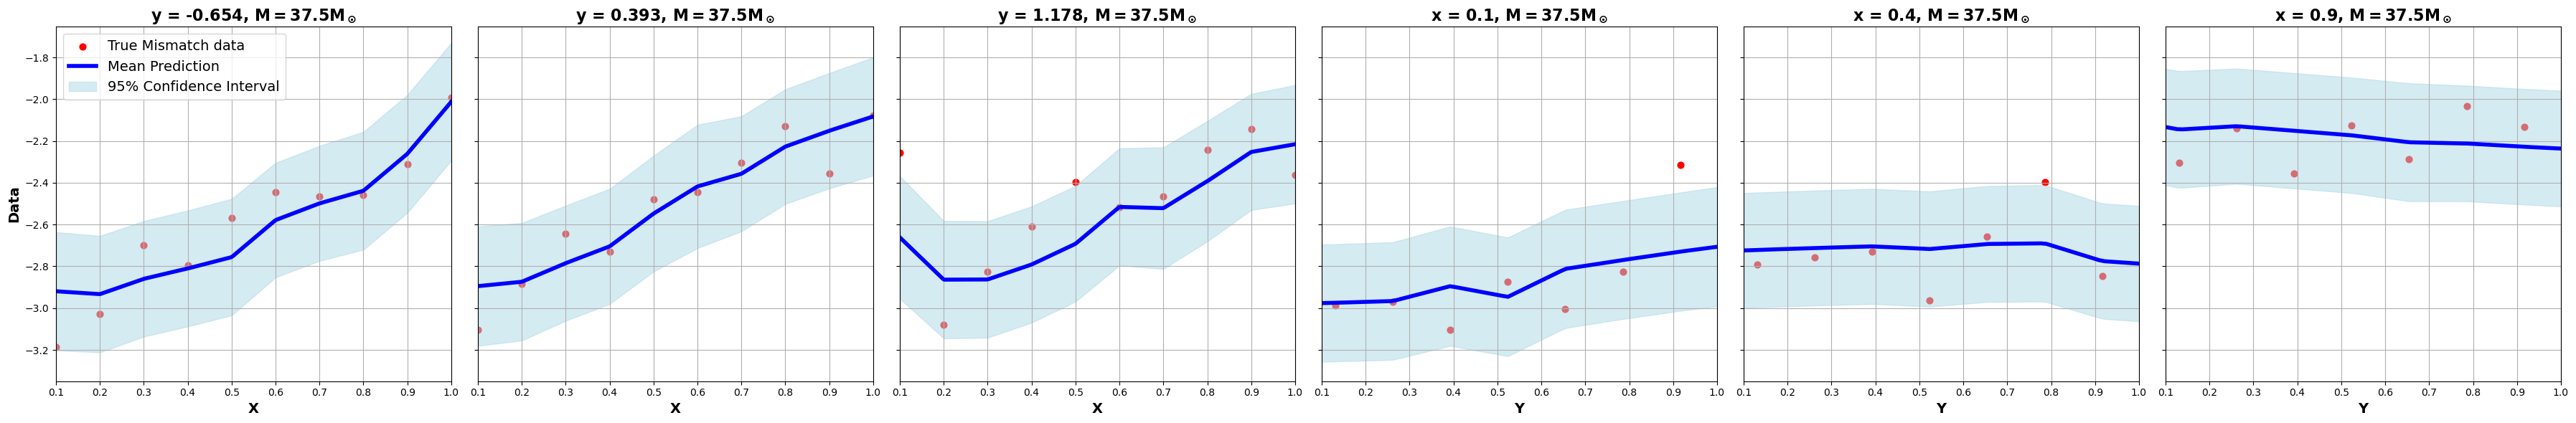

In [118]:
xpoints = np.linspace(0, 1, 250)
ypoints = [ -0.6544984694978736,0.39269908169872414,1.1780972450961724]
ypoints2 = np.linspace(-1.5, 1.5, 250)
xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]

# Initialize figure
fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=True)
j = 0
# Loop over the ypoints and create subplots
for i, ax in enumerate(axes):
    if (i<=2):
        ypoint = ypoints[i]
        
        zgridlinear_mean = griddata((xm1, ym1), Dfit, (xpoints, ypoint), method="linear")
        zgridlinear_std = griddata((xm1, ym1), Dstd, (xpoints, ypoint), method="linear")
        indices = np.isclose(ym1,ypoints[i])
        xdata = xm1[indices]
        mismatchdata = dm1[indices]
        
        ax.scatter(xdata,mismatchdata, s=40, color = 'red',label = 'True Mismatch data')
        ax.plot(xpoints, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=4)
        ax.fill_between(
            xpoints,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((0.1, 1))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
    else:
        xpoint = xpoints2[j]
        zgridlinear_mean = griddata((xm1, ym1), Dfit, (xpoint, ypoints2), method="linear")
        zgridlinear_std = griddata((xm1, ym1), Dstd, (xpoint, ypoints2), method="linear")
        indices = np.isclose(xm1,xpoints2[j])
        ydata = ym1[indices]
        mismatchdata = dm1[indices]
        
        ax.scatter(ydata,mismatchdata, s=40, color = 'red',label = 'True Mismatch data')
        ax.plot(ypoints2, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=4)
        ax.fill_between(
            ypoints2,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((0.1, 1))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
        j+=1

# Set common ylabel
axes[0].set_ylabel('Data', fontsize=14, weight='bold')

# Add legend to the first subplot
axes[0].legend(fontsize=14,loc='upper left')

# Adjust layout and show the plot
#plt.savefig("crosscuts", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()